In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
import random as rd # generating random numbers
import datetime # manipulating date formats
import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # for prettier plots
%matplotlib inline

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical
import math
from keras import backend as K

import warnings
warnings.filterwarnings("ignore")

In [ ]:
item_cat = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
sales_test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [ ]:
item_cat

In [ ]:
sales_train

In [ ]:
#formatting the date column correctly
sales_train.date=sales_train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [ ]:
sales_test

In [ ]:
monthly_sales=sales_train.groupby(["date_block_num","shop_id","item_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"}).reset_index()
monthly_sales.rename(columns={'item_cnt_day':'item_cnt_month'}, inplace=True)

In [ ]:
monthly_sales.drop(columns='item_price', inplace=True)
monthly_sales

In [ ]:
date_block_num_to_delete = [i for i in range(18)]
date_block_num_to_delete += [24 + k for k in range(6)]
print(date_block_num_to_delete)

In [ ]:
monthly_sales = monthly_sales[~monthly_sales['date_block_num'].isin(date_block_num_to_delete)]
# monthly_sales = pd.get_dummies(monthly_sales, columns=['date_block_num'])

In [ ]:
# number of items per cat 
x=items.groupby(['item_category_id']).count()
x=x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# #plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

In [ ]:
ts=sales_train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

In [ ]:
from sklearn.model_selection import train_test_split

X = monthly_sales.drop('item_cnt_month', axis=1)
y = monthly_sales['item_cnt_month']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# b. We chose the Random Forest Regressor as our classical ML model for prediciting the sales

In [ ]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1)
rfr.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
pred = rfr.predict(X_val)
# print("R2 score is " + str(r2_score(pred, y_val)))
print("RMSE is " + str(math.sqrt(mean_squared_error(pred, y_val))))

## As you can see, we got a solid benchmark.

# c. We create our embedding and input layers as preprocessing steps

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, embeddings_regularizer=l2(reg))(inp)

In [ ]:
n_shops = len(shops.nunique(axis=1))
n_items = len(items.nunique(axis=1))
n_months = monthly_sales['item_cnt_month'].nunique()
shops_in, shops_emb = embedding_input('shops_in', n_shops, math.ceil(min(50, math.sqrt(n_shops))), 1e-4)
items_in, items_emb = embedding_input('items_in', n_items, math.ceil(min(50, math.sqrt(n_items))), 1e-4)
months_in = Input(shape=(1,), dtype='int64', name='month_in'),

## d. We build a simple neural network which contains the embedding layers only.

In [ ]:
def plot_history():
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    print("Our model train and validation loss  are {} and {} respectivly ".format(history.history['loss'][-1],history.history['val_loss'][-1]))

In [ ]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
x = concatenate([shops_emb,items_emb])
x = Flatten()(x)
x = Dense(1, activation='relu')(x)
model = Model([months_in, shops_in, items_in], x)
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [ ]:
history = model.fit(x=[X.date_block_num, X.shop_id, X.item_id], y=y, validation_split=0.2, verbose=1, batch_size=64, epochs=5)
plot_history()

# e. We now modify our model by adding some bias for our embedding layers and some dropouts and batch normalization in order to generalize well and avoid overfit.
# In addition, we now pre-selected our train-validation split.

In [ ]:
x = concatenate([shops_emb,items_emb])
x = Flatten()(x)
x = BatchNormalization()(x)
# x = add([x,shops_bias])
# x = add([x, items_bias])
x = Dropout(0.15)(x)
x = Dense(25)(x)
x = Dropout(0.35)(x)
x = Dense(1, activation='relu')(x)
model = Model([months_in, shops_in, items_in], x)
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [ ]:
model.summary()

In [ ]:
history = model.fit(x=[X_train.date_block_num, X_train.shop_id, X_train.item_id], y=y_train, validation_data = ([X_val.date_block_num, X_val.shop_id, X_val.item_id],y_val), verbose=1, batch_size=64, epochs=5)
plot_history()

In [ ]:
sample_submission_df = pd.read_csv('../input/competitive-data-science-predict-future-sales/sample_submission.csv')

In [ ]:
pred = model.predict([pd.DataFrame([34] * len(sales_test)), sales_test.shop_id, sales_test.item_id])

In [ ]:
submission = pd.DataFrame.from_dict({'ID' : sample_submission_df['ID'], 'item_cnt_month' : pred.flatten()})

In [ ]:
filename = 'Future Sales Predictions.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

## Our position in the competition:
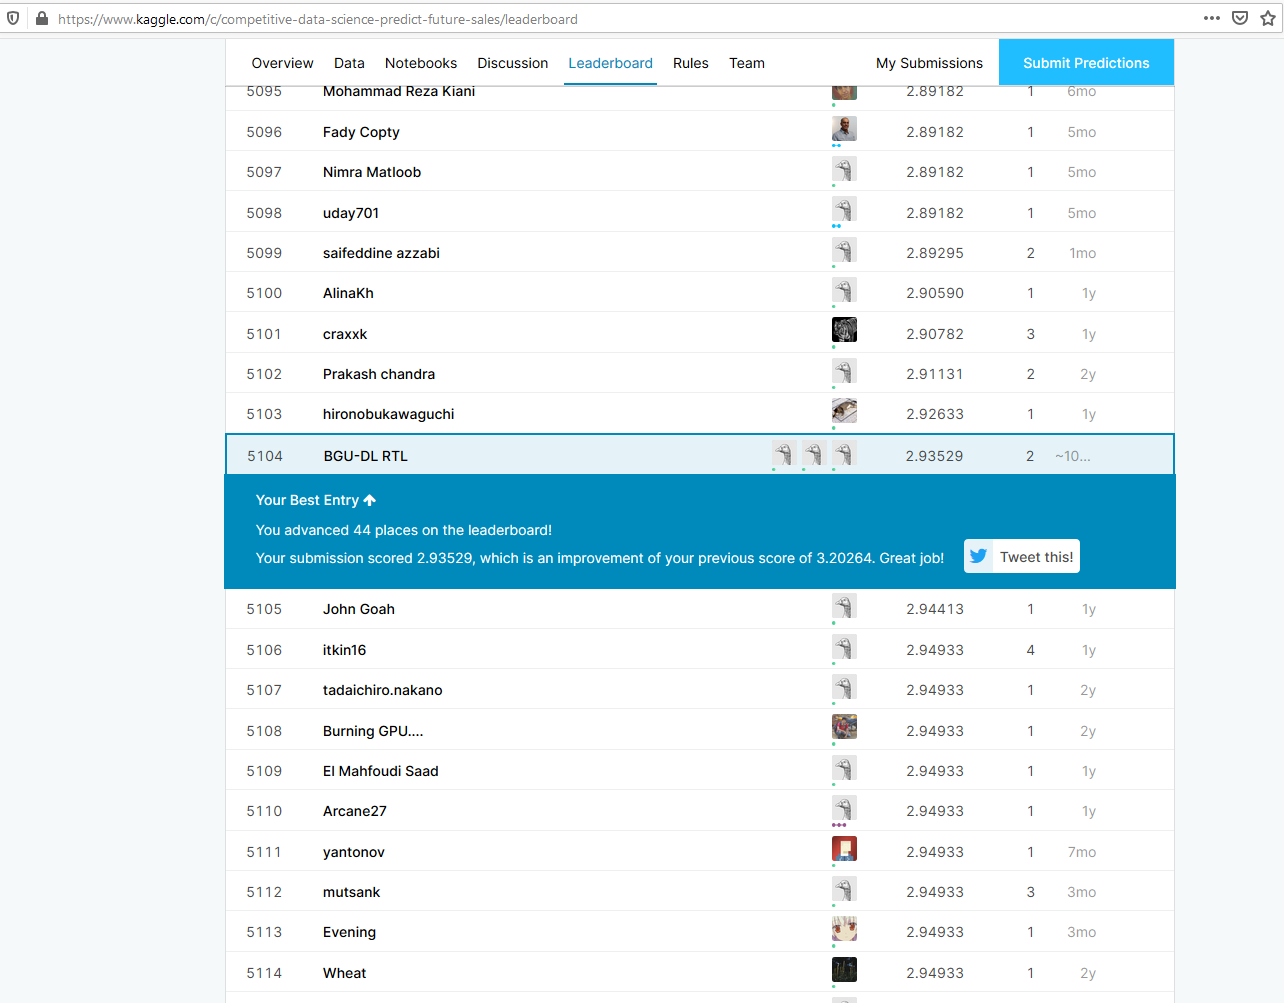

# f. 

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

items_emb_vect = model.layers[3].get_weights()[0]

pcas = pca.fit_transform(items_emb_vect)

plt.scatter(pcas[:20,0],pcas[:20,1], cmap='RdBu',c=range(20))

items[:20]

## From the above plot and table we can conclude that items with the same category are close to each other while items from different categories are further

In [ ]:
shops_emb_vect = model.layers[2].get_weights()[0]

pcas = pca.fit_transform(shops_emb_vect)

plt.scatter(pcas[:7,0],pcas[:7,1], cmap='RdBu',c=range(7))

shops[:7]

## Unlike the items, we weren't able to infer much about the shops from the embedding since there aren't any informative features we can use to find correlation

# g. We extract our model prediction on both train and validation sets as features for our classical ML model which will be the same as before (RFR)

In [ ]:
train_features = model.predict([X_train.date_block_num, X_train.shop_id, X_train.item_id], batch_size=64, verbose=1)
val_features = model.predict([X_val.date_block_num, X_val.shop_id, X_val.item_id], batch_size=64, verbose=1)

In [ ]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, verbose=1, random_state=42)
rfr.fit(train_features, y_train)

In [ ]:
pred = rfr.predict(val_features)
print("R2 score is " + str(r2_score(pred, y_val)))
print("RMSE is " + str(math.sqrt(mean_squared_error(pred, y_val))))

## As you can see we didn't manage to improve our results compared to our first RFR model. We can conclude that our self-learning task wasn't the best choice or that our pre-trained weights weren't optimal.